Student Details

Name:Michel Danjou

ID:18263461

Etivity 4

# Lab 4: Comparison of Classifiers

This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from scipy import interp

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support


C:\Users\danjou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Import evaluation and plotting functions

In [4]:
%run ./Lab4_Functions_18263461.ipynb

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [5]:
lab4_df = pd.read_csv("./seeds_dataset_binary.csv")
lab4_df.describe()


,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,0.333333
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.472531
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,0.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,1.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,1.000000


In [6]:
# target attribute
target = lab4_df['type']

# predictor attributes
predictors = lab4_df.drop('type', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

In [7]:
# Some sanity checks in the target to reveal how inbalanced it is (2/3 zeros, 1/3 ones)
print(target.describe())
print(target.values)

print("Nb of 0s in target:", np.bincount(target)[0])
print("Nb of 1s in target:", np.bincount(target)[1])
print("Nb samples       :", np.bincount(target)[0] + np.bincount(target)[1])


count    210.000000
mean       0.333333
std        0.472531
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: type, dtype: float64
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Nb of 0s in target: 140
Nb of 1s in target: 70
Nb samples       : 210


### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [8]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [9]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, _recalls_SVM, _precisions_SVM = evaluate_classifier(folds=5, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

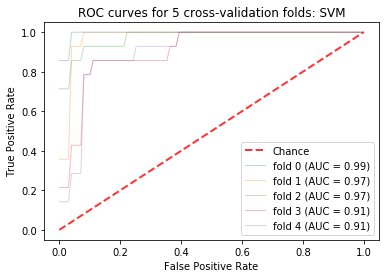

In [10]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

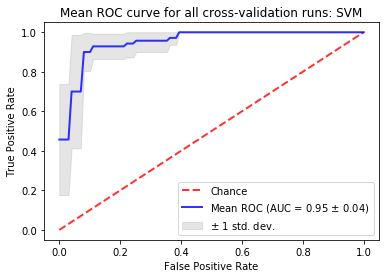

In [11]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [12]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB, _recalls_NB, _precisions_NB = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

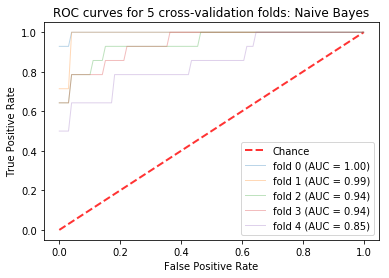

In [13]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

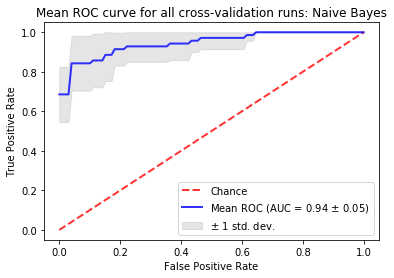

In [14]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Compare All Trained Classifiers

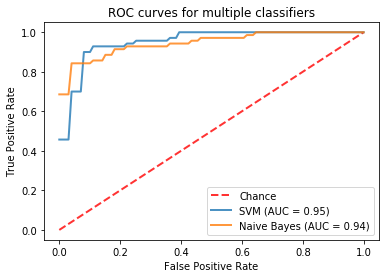

In [15]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB)]), 
                              np.array(['SVM', 'Naive Bayes']))

In [16]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB})

In [17]:
accuracies_df.describe()

,SVM,Naive Bayes
count,5.000000,5.000000
mean,0.876190,0.880952
std,0.045799,0.078967
min,0.809524,0.761905
25%,0.857143,0.857143
50%,0.880952,0.880952
75%,0.904762,0.952381
max,0.928571,0.952381


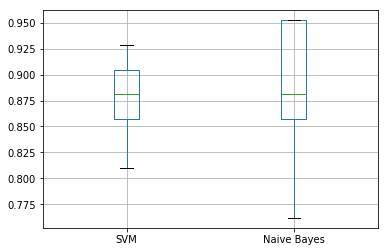

In [18]:
accuracies_df.boxplot()

In [19]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB})

In [20]:
f1_scores_df.describe()

,SVM,Naive Bayes
count,5.000000,5.000000
mean,0.804812,0.824418
std,0.056227,0.116353
min,0.750000,0.642857
25%,0.769231,0.800000
50%,0.782609,0.827586
75%,0.833333,0.923077
max,0.888889,0.928571


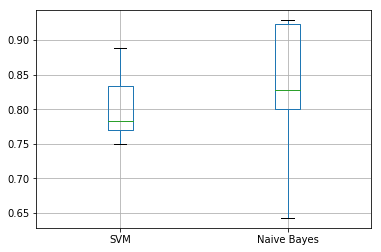

In [21]:
f1_scores_df.boxplot()

#### Conclusion

In this example, both the SVM and the Naive Bayes classifiers have mean accuracy approximately 88%, which is quite high. The ROC curves do not suggest a clear winner, although it can be noted that Naive Bayes can achieve TPR above 80% for a lower FPR than SVM. On the other hand, the accuracy of the five folds of Naive Bayes show higher variance than the accuracy of the five folds of SVM, and low variance is desirable. Still, the lowest accuracy of Naive Bayes is above 75% which is not bad. Similar observation can be made about the F1 score. Naive Bayes has a higher mean F1 score but also higher variance. Since both SVM and Naive Bayes have high mean accuracy, high mean F1 score and a very similar AUC, while SVM appears to have visibly lower variance than Naive Bayes, we can conclude that perhaps SVM is a safer choice for a best model. 

It will be interesting to plot precision and recall for a more detailed comparison. Since the two classes are not well balanced (1/3 of the examples are in class 1), a precision-recall curve a more detailed study of the precision and recall can provide better information than the ROC curves for picking the best model.

## C. FInal Model

Assuming SVM was chosen, now we can train a final (to be potentially deployed) SVM model with the whole dataset:

In [22]:
model = NB_classifier.fit(predictors, target)

Use the model to predict the type of three new seeds:

In [23]:
new_seeds = np.array([[0.4,0.5,0.6,0.5,0.5,0.2,0.3], [0.0,1.0,0.0,1.0,0.5,0.5,0.2], [0.2,0.2,0.2,1.0,0.2,0.2,0.2]])

In [24]:
# Probabilistic prediction
np.round(model.predict_proba(new_seeds), 2)
# Note: 
#   - the first column are the probabilities for the three new seeds to belong to class 0
#   - the second column are the probabilities for the three new seeds to belong to class 1

array([[0.01, 0.99],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [25]:
# Exact prediction
model.predict(new_seeds)

array([1, 0, 0], dtype=int64)

# Task 1
  * Watch the video playlist CS5062-E-tivity4 (ca. 40 min).
  * Read the article How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python.
  * Use the following files (available in the GitLab repository):
    * **Lab 4 - Comparison of Classifiers - Main.ipynb** - This is the main example notebook to follow these two weeks. It contains code for training and evaluating SVM and Naïve Bayes classifiers.
    * **Lab4_Functions.ipynb** - This notebook contains some functions used in the man example notebook. They have been put in a separate file to keep the main notebook easier to follow.
    * **seeds_dataset_binary.csv** - This is the data set used in the main example notebook.
    * **data set loans_et4.csv**. This is a modified version of the loans data set with 1 for Loan_Status = Yes and 0 for Loan_Status = No. You are asked to work with this data set in Tasks 1-3.
 * Replicate the classifier training and evaluation demonstrated in the main example notebook **Lab 4 - Comparison of Classifiers - Main.ipynb** but with the data set **loans_et4.csv** and target attribute **Loan_Status**. Then train another probabilistic classifier with loans_et4.csv add compare it to both SVM and Naïve Bayes. For this third classifier, you can pick any scikit-learn probabilistic classification algorithm apart from SVM and Naive Nayes. Summarise your conclusions (max 150 words in a markdown cell).
 
#### Rubric
  * Beginning: The third probabilistic classifier not trained successfully.
  * Developing: The third probabilistic classifier trained successfully but not evaluated correctly.
  * Accomplished: The third probabilistic classifier trained successfully and compared to SVM and Naive Bayes in terms of plots. Conclusions may not reflect the evaluation of classifiers correctly.
  * Exemplary: The third probabilistic classifier trained successfully and compared to SVM and Naive Bayes. Conclusions reflect the evaluation of classifiers correctly.
    

In [26]:
loans_df = pd.read_csv("./loans_et4.csv")
loans_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [27]:
# target attribute
target = loans_df['Loan_Status']

# predictor attributes
predictors = loans_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

In [28]:
# look inside the target.
print(target.describe())
print(target.values)

print("Nb of 0s in target:", np.bincount(target)[0])
print("Nb of 1s in target:", np.bincount(target)[1])
print("Nb samples       :", np.bincount(target)[0] + np.bincount(target)[1])


count    480.000000
mean       0.691667
std        0.462287
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Loan_Status, dtype: float64
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

The target is **inbalanced**:
  * 30.8% of the samples are zeros 
  * 69.1% of the samples are ones

In [29]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

### SVM

In [30]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, _recalls_SVM, _precisions_SVM = evaluate_classifier(folds=5, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)


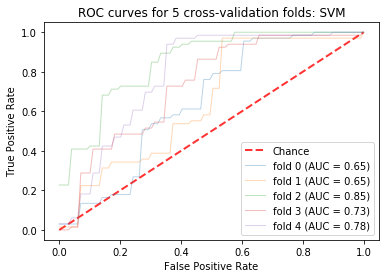

In [31]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

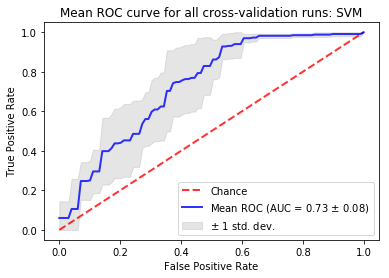

In [32]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Bayes

In [33]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB, _recalls_NB, _precisions_NB = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)


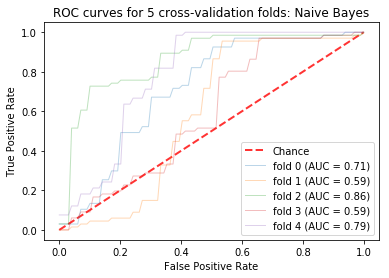

In [34]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

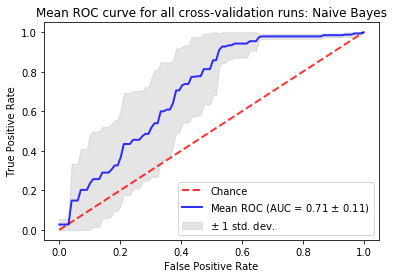

In [35]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Random Forrest

In [36]:
RF_classifier = RandomForestClassifier(n_estimators=100, max_depth=4,
                             random_state=0)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF, f1_scores_RF, tprs_RF, aucs_RF, _recalls_RF, _precisions_RF = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=RF_classifier, 
                                                                    mean_fpr=mean_fpr)


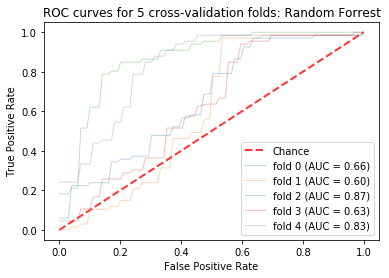

In [37]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF, aucs_RF, 'Random Forrest')

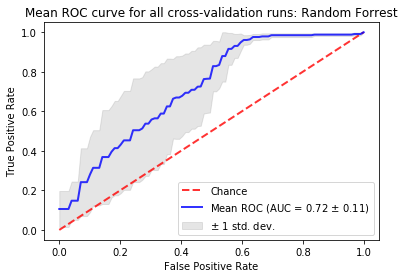

In [38]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF, aucs_RF, 'Random Forrest')

###  Compare classifiers

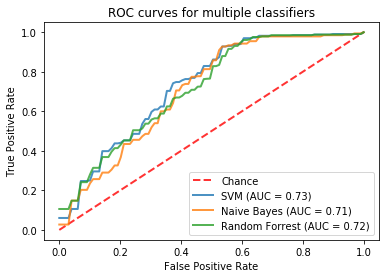

In [39]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0), np.mean(tprs_RF, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(aucs_RF)]), 
                              np.array(['SVM', 'Naive Bayes', 'Random Forrest']))

The ROC curves for Naive Bayes and Random Forrest match each other.

In [40]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'Random Forest' : accuracies_RF})

In [41]:
accuracies_df.describe()

,SVM,Naive Bayes,Random Forest
count,5.000000,5.000000,5.000000
mean,0.808403,0.791670,0.791887
std,0.029567,0.053465,0.043464
min,0.778947,0.715789,0.731959
25%,0.783505,0.762887,0.778947
50%,0.812500,0.804124,0.793814
75%,0.814433,0.822917,0.802083
max,0.852632,0.852632,0.852632


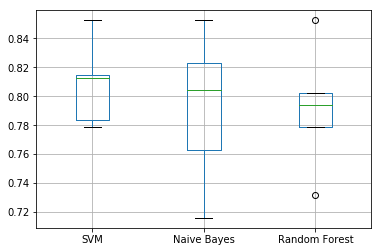

In [42]:
accuracies_df.boxplot()

In [43]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB, 'Random Forest' : f1_scores_RF})

In [44]:
f1_scores_df.describe()

,SVM,Naive Bayes,Random Forest
count,5.000000,5.000000,5.000000
mean,0.876278,0.860583,0.863729
std,0.017193,0.036598,0.029879
min,0.860927,0.808511,0.819444
25%,0.860927,0.839161,0.860927
50%,0.878378,0.872483,0.863014
75%,0.878378,0.882759,0.872483
max,0.902778,0.900000,0.902778


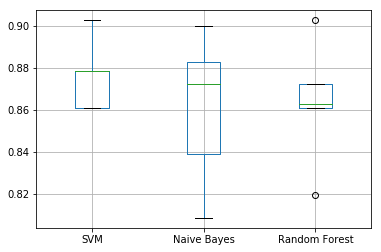

In [45]:
f1_scores_df.boxplot()


#### Overall observations:
  * The ROC curves are very similar to each other and do not allow us to favor one particular algorithm over another.

  
#### Random Forest vs Naive Bayes

  
  * Random Forest and Naive Bayes **mean accuracy** are simialar at 0.791670 and 0.791887 respectively. However, the variance of the Naive Bayes estimator is higher than for the Ramdom Forest as can be seen on the box plot, and also by looking at the **standard deviation** in the table which is the **square root of the variance**.
  
  * Random Forest and Naive Bayes **mean F1** score are similar at 0.864 and 0.86 respectively, however the variance of the Naive Bayes estimator is higher than for the Random Forest as can be seen on the box plot. 

#### Random Forest vs SVM

  * Random Forest has a lower mean accuracy and f1_score (0.791887 and 0.863729 respectively) than SVM. (0.808403 and 0.876278 respectively) 
  * Random Forest has a higher accuracy and f1_score standard deviation than SVM.
  * Overall, the performance of the Random Forest is inferior to SVM's.

#### Conclusion
An overal comparison between the 3 estimators shows that SVM is still the better estimator followed by Random Forest which itself is only better than Naive Bayes thanks to a tighter variance.

We notice that the **accuracy and f1_scores** are much **lower** on **loan** data set than on the **seeds** data set. This is **not due to the imbalance on the target feature** which is identical for both data sets. This shows that even after performing normalisation, we are not guaranteed the same results from one data set to another. In other words, an estimator might perform well on a data set and poorly on another. 


# Task 2
  * Modify the code in both **Lab 4 - Comparison of Classifiers.ipynb** and **Lab4_Functions.ipynb** to boxplot precision and recall for the classifiers trained with loans_et4.csv. 
  * Update your conclusions from Task 1 after evaluating precision and recall.

#### Rubric
  * Beginning: Neither precision and recall plots attempted or implemented successfully.
  * Developing: Precision and recall plots implemented partially. Conclusion about the comparison of the classifiers incomplete.
  * Accomplished: Both precision and recall plots implemented successfully. Conclusion about the comparison of the classifiers does not reflect the observations about precision and recall correctly.
  * Exemplary: Both precision and recall plots implemented successfully. Conclusion about the comparison of the classifiers reflects the observations about precision and recall correctly.

In [46]:
# Compare the statistics of the precision across all cross-validation folds
precision_df = pd.DataFrame(data={'SVM' : _precisions_SVM   , 'Naive Bayes' : _precisions_NB    , 'Random Forrest' : _precisions_RF})
precision_df.describe()

,SVM,Naive Bayes,Random Forrest
count,5.000000,5.000000,5.000000
mean,0.793400,0.800727,0.788975
std,0.026854,0.033546,0.028196
min,0.764706,0.760000,0.764706
25%,0.773810,0.789474,0.766234
50%,0.792683,0.792683,0.783133
75%,0.802469,0.810127,0.797468
max,0.833333,0.851351,0.833333


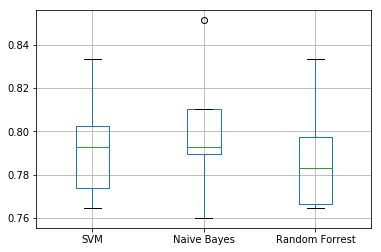

In [47]:
precision_df.boxplot()

In [48]:
# Compare the statistics of the recalls across all cross-validation folds
recalls_df = pd.DataFrame(data={'SVM' : _recalls_SVM   , 'Naive Bayes' : _recalls_NB    , 'Random Forrest' : _recalls_RF})
recalls_df.describe()

,SVM,Naive Bayes,Random Forrest
count,5.000000,5.000000,5.000000
mean,0.978969,0.930710,0.955088
std,0.008051,0.048427,0.045893
min,0.970149,0.863636,0.880597
25%,0.970149,0.895522,0.940299
50%,0.984848,0.954545,0.984848
75%,0.984848,0.969697,0.984848
max,0.984848,0.970149,0.984848


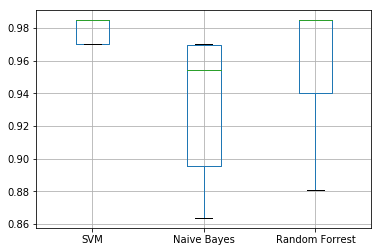

In [49]:
recalls_df.boxplot()

#### Conclusion
Precision and recall are important metrics:
  * The recall represents the ability for a model to find all the relevant cases in the data set.
  * The precision represents the proportion of data points it identifies are relevant which are actually relevant.

In terms of **recalls**, **SVM has a clear lead** with a mean value of 0.978969, followed by Random Forest at 0.955088 and Naive Bayest at 0.930710. The variance of the recalls is also a lot smaller for SVM than for the rest of the estimators which is highly desirable.

We can see that the **precision is highest for Naive Bayes** at 0.8 followed very closely by SVM at 0.7934 and Random Forrest at 0.78895. However, the standard deviation given by Panda's `describe()` function, is smaller for SVM than for any other estimator. Since standard deviation is also the square root of the variance, we can say that SMV produces a more concentrated precision score than the other estimators which is an important factor..
  
Globally, we are looking for the model with the highest precision and recall. We can see that SVM is the extremely capable at recalling all the data set and has a very high and stable precision.  
**SVM is our best estimator.**



# Task 3

  * Pick a winner among the classifiers you have trained with loans_et4.csv. 
  * Assume that it is important to minimise the false positives (i.e., Loan_Status predicted to be 1 wrongly). 
  * Look up the training parameters for this classifier on the scikit-learn website. 
    * For example, SVM has more than 10 parameters (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 
    * Experiment with the parameters and see if you can improve the model in terms of accuracy, precision, recall and AUC.
    * You do not have to build a better model but to show that you have explored some of its training parameters. 
    * Summarise your experience with exploring the parameters (max 150 words in a markdown cell).

#### Rubric
  * Beginning: Best classifier not identified.
  * Developing: Best classifier identified. Parameter exploration either not attempted or unsuccessful.
  * Accomplished: Best classifier identified. Parameter exploration attempted but either poorly presented or not summarised correctly.
  * Exemplary: Best classifier identified. Parameter exploration implemented successfully, presented well and summarised correctly. 

References: 
  * https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
  * https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

#### Classifier parameters
Let's start by printing the parameters used by the SVM classifiers we have used so far:

In [50]:
SVM_classifier.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### Best classifier parameters

Let's use GridSearchCV to find the best parameters for the classifiers.

In [51]:
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

import time

def make_svc_grid_search(nfolds, scoring):
    probas=[True]    
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 2]
    kernels=['linear', 'poly', 'rbf']
    degrees =[2,3,4]
    class_weight =[None, {0: 1 , 1: 3}] 
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels, 'degree': degrees, 'probability' : probas, 'class_weight' : class_weight }
    
    svm_classifier = svm.SVC()
    
    return get_grid_search(svm_classifier, param_grid, nfolds, scoring)


def get_grid_search(estimator, param_grid, nfolds, scoring):
    if (scoring=='default'):
        return GridSearchCV(estimator, param_grid, cv=nfolds)
    else:
        return GridSearchCV(estimator, param_grid, cv=nfolds, scoring=scoring)


def run_gridsearch(grid_search, X, y):
    start = time.time()
    print("Starting Grid search. Takes up to 3-5 minutes...")

    grid_search.fit(X, y)
    grid_search.best_params_
    
    end = time.time()
    print("best params:{} found in {} sec".format(grid_search.best_params_, end - start))
    print("best score :", grid_search.best_score_ )
    return grid_search.best_params_, grid_search.best_estimator_, grid_search.best_score_



C:\Users\danjou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\danjou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Using SVM default scoring function

In [52]:
gridsearch_default_SVC_params, gridsearch_default_SVC, gridsearch_default_SVC_score = run_gridsearch(make_svc_grid_search(10, 'default'), predictors, target)

Starting Grid search. Takes up to 3-5 minutes...
best params:{'C': 0.001, 'class_weight': None, 'degree': 3, 'gamma': 2, 'kernel': 'poly', 'probability': True} found in 374.20184683799744 sec
best score : 0.8083333333333333


#### Using roc_auc as SVM scoring function

In [53]:
best_SVC_params, best_SVC, best_SVC_score = run_gridsearch(make_svc_grid_search(10, 'roc_auc'), predictors, target)

Starting Grid search. Takes up to 3-5 minutes...
best params:{'C': 0.001, 'class_weight': None, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'probability': True} found in 355.335098028183 sec
best score : 0.7586822001527884


In [54]:
def run_classifiers_2(clfs, titles):
    
    for index, clf in enumerate(clfs):
        plt.figure(figsize=(25, 5)) 
        p = 141    
        clf_name = titles[index]

        accuracies, f1_scores, tprs, aucs, _precisions, _recalls = evaluate_classifier(folds=5, 
                                                                            p=predictors, t=target, 
                                                                            classifier=clf, 
                                                                            mean_fpr=mean_fpr)
        
        plt.subplot(p, frameon=False)
        plot_roc_cv_folds_michel(mean_fpr, tprs, aucs, clf_name, "FP", "TP", show=False)

        p += 1
        plt.subplot(p, frameon=False)
        plot_roc_mean_michel(mean_fpr, tprs, aucs, clf_name, "FP", "TP", show=False)

        plt.tight_layout() 
        plt.show()



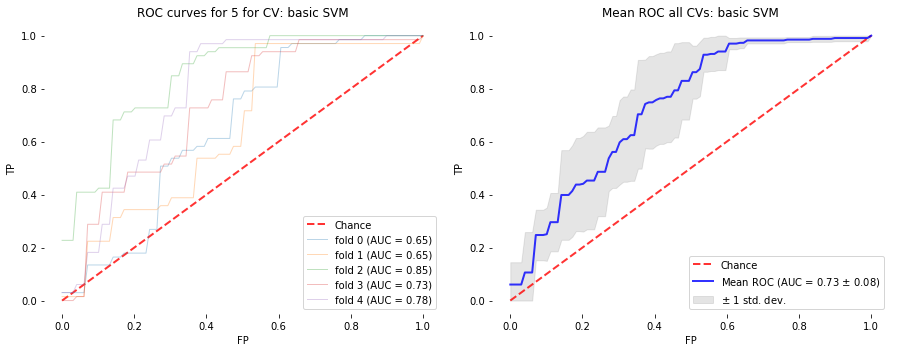

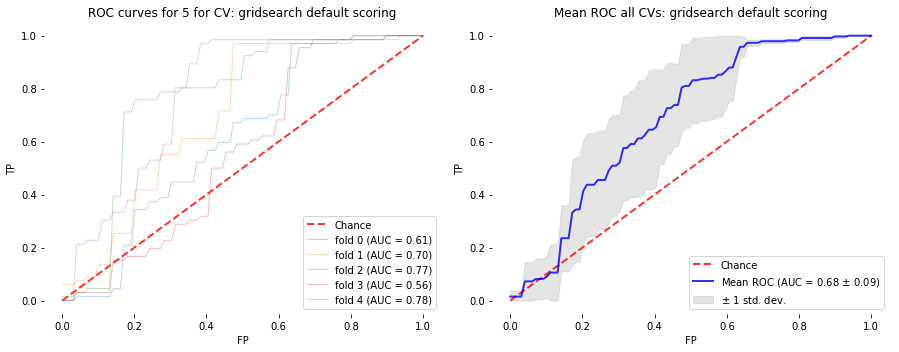

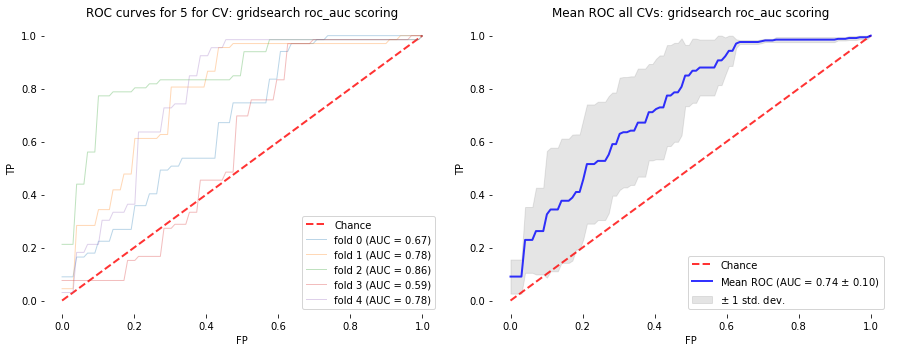

In [55]:
# Using classifiers with default values
clfs = [SVM_classifier, gridsearch_default_SVC, best_SVC]
titles = ['basic SVM', 'gridsearch default scoring', 'gridsearch roc_auc scoring']
run_classifiers_2(clfs, titles)

The results are as follows:

|  Mean ROC recall by precision | GridSearchCV | Estimator scoring | Mean Roc Value  | Comment  |
|---|---|---|--|--|
|  **SVC** | **no** | **mean accuracy (default)** |<span style="color:blue">**0.73**</span> |  **+/- 0.08**|
|  **SVC**  | **yes** | **mean accuracy (default)**  |  <span style="color:red">**0.68**</span>|  **+/- 0.09** |
|  **SVC** | **yes** | **roc_auc** | <span style="color:green">**0.74**</span> | **+/- 0.1** |


#### Observations regarding SVC scoring functions:
After multiple runs of the grid search, it emerged that the scoring function has a lot of impact on our search for the best parameters. 
Changing SVM's scoring function from the default `mean accuracy` to `roc_auc`, increased the mean ROC from 68% to 74%. 

#### Observations regarding the Imbalanced target 
GridsearchCV was given the option to either use No `class_weights` or `class_weights` that match the actual distribution of the target.
Curiously, gridsearchCV returned an estimator with **No** `class_weights`. This is surprising since the target is clearly unbalanced. 

#### Observation regarding the order of the function used by the estimator
The differences in terms of parameters between the best version of SVM and the worst is as follows:  
Gamma:
  * Best SVM gamma: **0.01** 
  * worst SVM gamma: **2**
  
Degree:  
  * Best SVM degree: **2** 
  * worst SVM degree: **3** 
  
Here we see that a low order model was able to better estimate the target function than a higher degree one. This could be due to the fact that higher degree models tend to incorporate **noise** more during learning, which is an issue that could be overcome using the appropriate **regularization** technique.

#### And the winner is
**SVC default is the winner but ...**. gridsearchCV using `roc_auc` only generated a 0.1% increment over the original version of the SVM estimator.(variance at 0.1%).  In the end the improvement over the initial version of the SVM estimator was nearly **insignificant** 

In [56]:
# Retrieve parameters for all classifiers
print(SVM_classifier.get_params)
print(best_SVC.get_params)

<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
<bound method BaseEstimator.get_params of SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.001, kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
